# Homework 4

**Yiğit Berk SARIBOĞA**

In [ ]:
import pandas as pd
import numpy as np
import gzip
from urllib.request import Request, urlopen
import librosa
import librosa.display
import matplotlib.pyplot as plt
from librosa.util import fix_length
from collections import Counter
import networkx as nx
import scipy as sp
from scipy.sparse import coo_matrix

# Question 1

For this question we are going to use [Amazon Fine Foods reviews](http://snap.stanford.edu/data/web-FineFoods.html) from [Stanford Network Analysis Project (SNAP)](http://snap.stanford.edu/index.html).

**Step 1:** Ingest the data as pandas dataframe.

**Step 2:** Calculate the average score for each product and store is as a pandas dataframe.

**Step 3:** From the original dataframe filter out (remove) all products that has less than 100 reviews. Get the resulting list of productId's. How many products do we have satisfying this condition?

**Step 4:** From the original dataframe filter out (remove) all users that has less than 50 reviews. Get the resulting list of userId's. How many users do we have satisfying this condition?

**Step 5:** On the original dataframe filter out (remove) all users that has less than 50 reviews and all products that has less than 100 reviews. Use the lists from Step 4 and 5.

**Step 6:** Create a pivot table for userId's vs productId's.

**Step 7:** Normalize each row by dividing each row with the sum of that row. Call the dataframe result

**Step 8:** Multiply result with its transpose result.T in two different ways. Now, you obtained two similarity matrices: one for users, the other for products.

**Step 9:** Construct a networkx network of users and a networkx network of products. Sketch the networks. Observe that these networks are too complicated to understand.

**Step 10:** Remove some edges by setting threshold for the similarity value. Experiment few values and choose an appropriate value, and sketch the final results for both user and product networks.

## Answers

### Step 1

Getting the text data as pandas dataframe.

In [2]:
with open('foods.txt','r', encoding='latin-1') as f:
    data = f.read()
    df= pd.DataFrame([
    {line.split(': ')[0]:': '.join(line.split(': ')[1:])
     for line in record.split('\n')}
        for record in data.split('\n\n')])
df = df.drop(df.columns[8:13], axis=1).dropna()     

In [3]:
df

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0/0,5.0,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0/0,2.0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2/2,5.0,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1/1,5.0,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


### Step 2

Calculating the average score for each product and user as pandas dataframes.

In [4]:
df['review/score'] = pd.to_numeric(df['review/score'],errors='coerce')
df.groupby('product/productId')[['review/score']].mean()

,review/score
product/productId,
0006641040,4.351351
141278509X,5.000000
2734888454,3.500000
2841233731,5.000000
7310172001,4.751445
...,...
B009UOFTUI,1.000000
B009UOFU20,1.000000
B009UUS05I,5.000000


In [5]:
df['review/score'] = pd.to_numeric(df['review/score'],errors='coerce')
df.groupby('review/userId')[['review/score']].mean()

,review/score
review/userId,
#oc-R103C0QSV1DF5E,5.000000
#oc-R109MU5OBBZ59U,5.000000
#oc-R10LFEMQEW6QGZ,5.000000
#oc-R10LT57ZGIB140,3.000000
#oc-R10UA029WVWIUI,1.000000
...,...
AZZV9PDNMCOZW,4.666667
AZZVNIMTTMJH6,5.000000
AZZY649VYAHQS,5.000000


### Step 3

The process of removing all products with less than 100 reviews from the original dataframe.

In [6]:
product_count = Counter(df['product/productId'])
pc = pd.DataFrame.from_dict(product_count, orient='index').reset_index()
pc.columns = ['productId', 'reviews']
prods = pc.drop(pc.loc[pc['reviews'] < 100].index).sort_values('reviews', ascending=False)
prods

,productId,reviews
73685,B007JFMH8M,913
2787,B002QWP89S,632
9294,B0026RQTGE,632
46018,B002QWP8H0,632
42761,B002QWHJOU,632
...,...,...
70949,B003CK7MME,101
1893,B002TMV34E,100
1683,B004P4TL8E,100
65778,B000H241DS,100


Getting the resulting list of productId's

In [ ]:
product_list = list(prods['productId'])

Creating the new dataframe in which products with less than 100 reviews are removed.

In [8]:
df_product = df.loc[df['product/productId'].isin(product_list)].reset_index(drop=True)
df_product

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000G6RYNE,A2NO1TXXS9T0EE,BruteNStones,0/0,4.0,1335398400,Hard,"Great if you are cutting back on fat, they do ..."
1,B000G6RYNE,A1IRN1M05TPOVT,"Sharon M. Helfand ""Scrapper""",0/0,5.0,1334620800,Kettle potato chips: Fully loaded baked potato,I have never met a Kettle brand chip I did not...
2,B000G6RYNE,ARONI7W0W677H,Peter N,0/0,5.0,1334275200,"Fresh, Lightly-Spiced, Crunchy Kettle Chips. G...",After buying bags one at a time (at a hefty ma...
3,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0/0,4.0,1334016000,glad to find them in 1 oz size,"I buy mostly for vending, so the size of the b..."
4,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0/0,4.0,1334016000,"pretty good, could be better",Glad to find these in a one ounce size but the...
...,...,...,...,...,...,...,...,...
176020,B0030VJ8YU,A2SY8HZ1959H41,irvinejess,0/0,1.0,1344816000,Yucky!,My son loves all of the Happy Baby meals he's ...
176021,B0030VJ8YU,AL4269Y3JX766,NewMama,0/0,3.0,1336521600,Original Recipe was better.....baby no longer ...,Unfortunately they changed the recipe up on ou...
176022,B0030VJ8YU,A1WZFAP5YHQNZV,E. Lee,0/0,4.0,1335398400,"Good flavor, surprisingly chunky",This was much chunkier than I expected. Our b...
176023,B0030VJ8YU,A3IFDLRQBY4MW5,kitty pinkerton,0/0,3.0,1335225600,Thumbs down for the new ingredient,I was a big fan of this product since it was t...


There are 866 products that satisfy the condition of not reviewing less than 100.

In [9]:
len(prods)

866

### Step 4

The process of removing all users with less than 50 reviews from the original dataframe.

In [10]:
user_count = Counter(df['review/userId'])
uc = pd.DataFrame.from_dict(user_count, orient='index').reset_index()
uc.columns = ['userId', 'reviews']
ucs = uc.drop(uc.loc[uc['reviews'] < 50].index).sort_values('reviews', ascending=False).dropna()
ucs

,userId,reviews
367,A3OXHLG6DIBRW8,448
1270,A1YUL9PCJR3JTY,421
108,AY12DBB0U420B,389
1338,A281NPSIMI1C2R,365
142,A1Z54EM24Y40LL,256
...,...,...
29881,A18L1CVUIQRE9L,50
10358,A2AOD7254MCKSH,50
37224,A12ENBT314RFXR,50
4344,A1H7Y5XKPGT0OS,50


Getting the resulting list of userId's

In [ ]:
user_list = list(ucs['userId'])

Creating the new dataframe in which users with less than 50 reviews are removed.

In [12]:
df_user = df.loc[df['review/userId'].isin(user_list)].reset_index(drop=True)
df_user

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4/5,5.0,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
1,B001EO5QW8,A2G7B7FKP2O2PU,D. Leschke,0/0,5.0,1209686400,Great taste and convenience,We really like the McCann's steel cut oats but...
2,B001EO5QW8,AQLL2R1PPR46X,grumpyrainbow,0/0,5.0,1192752000,good,Good oatmeal. I like the apple cinnamon the b...
3,B001REEG6C,AY12DBB0U420B,Gary Peterson,0/0,5.0,1316390400,My Idea of a Good Diet Food.,I'm presently on a diet and I was at my Fresh ...
4,B001GVISJW,A2YIO225BTKVPU,"Angel_Boy ""Treat the people around you the wa...",0/0,4.0,1301788800,Good Licorice,Twizzlers brand licorice is much better than t...
...,...,...,...,...,...,...,...,...
22936,B00374ZKQ0,A2GEZJHBV92EVR,History buff,0/0,5.0,1345075200,Very good alternative to sugar.,I have tried many of the no sugar sweeteners o...
22937,B0013Z0PTW,A1ODOGXEYECQQ8,Nuknuk,0/0,4.0,1226880000,Good Tasting Granola Bars,Most health bars taste awful. Fiber One Grano...
22938,B001BOAOLY,A36MP37DITBU6F,"Enchanted In Dixie ""Enchanted""",6/6,4.0,1244419200,GREAT ORGANIC Honey flavor Hard candy. Great c...,These are delicious organic hard candies. I on...
22939,B000LKVRQA,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1/1,5.0,1282608000,An Earl Grey Tea That Won't Disappoint,*****<br />St. Dalfour's wonderful Certified O...


There are 267 users that satisfy the condition of not reviewing less than 50.

In [13]:
len(ucs)

267

### Step 5

Removing all users with less than 50 reviews and all products with less than 100 reviews from the original dataframe using the lists in Steps 4 and 5.

In [14]:
raw_df = df.loc[df['review/userId'].isin(user_list)].reset_index(drop=True)
clean_df = raw_df.loc[raw_df['product/productId'].isin(product_list)].reset_index(drop=True)
clean_df

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000G6RYNE,A2OEUROGZDTXUJ,J. Graves,0/0,5.0,1327881600,Delicious!,"Now, I haven't done a side-by-side comparison,..."
1,B000G6RYNE,A22PUBSSNP54L,"G. Little ""value seeker""",0/0,5.0,1326672000,I love these chips. They are thick and crunchy!,These chips are thick and crunchy. I absolute...
2,B000G6RYNE,AYB4ELCS5AM8P,"John B. Goode ""JBG""",0/0,5.0,1300579200,Excellent!,What I like about them:<br />1) Very thick chi...
3,B000G6RYNE,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",0/0,3.0,1288915200,An Acquired Taste,"OK,I did read the reviews which ranged from sp..."
4,B000G6RYNE,A3RMGIKUWGPZOK,Jean Visnefski,0/0,5.0,1245024000,One of Their Best Flavors,Kettle Chips flavors can be hit or miss. Some...
...,...,...,...,...,...,...,...,...
7222,B0030VJ8YU,A4DTM6B4IBYQX,C.O.,9/9,5.0,1296950400,L O V E Chick Chick,"I make a lot of my own baby food, but was not ..."
7223,B0030VJ8YU,A20P8VC55KPPCT,FL Mom,3/3,5.0,1274486400,These pouches are great!,These pouches are so easy and convenient. They...
7224,B0030VJ8YU,A4DTM6B4IBYQX,C.O.,2/2,2.0,1299888000,Um... no thanks (sorry Happy Baby),"IF THIS IS YOUR FIRST HAPPY BABY PURCHASE, TRY..."
7225,B0030VJ8YU,A20P8VC55KPPCT,FL Mom,2/2,5.0,1274486400,These pouches are great!,These pouches are so easy and convenient. They...


### Step 6

Creating a pivot table for userId's vs productId's.

In [15]:
clean_df = clean_df.rename(columns={'product/productId': 'productId', 'review/userId': 'userId'})
pivottable = pd.crosstab(clean_df.productId,clean_df.userId)
pivottable

userId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
productId,,,,,,,,,,,,,,,,,,,,,
7310172001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7310172101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00004CI84,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
B00004CXX9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
B00004RYGX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00954NY46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00954NYVY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0098WV8F2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Step 7

Normalizing each row by dividing each row with the sum of that row and calling the dataframe as "result".

In [16]:
result = pivottable.div(pivottable.sum(axis=1), axis=0)
result

userId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
productId,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
B00004CI84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
B00004CXX9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
B00004RYGX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00954NY46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
B00954NYVY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
B0098WV8F2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Step 8

Multiplying result with its transpose in two different ways. Then, obtaining two similarity matrices: one for users, the other for products.

In [17]:
matrix1 = result.dot(result.T)
matrix1

productId,7310172001,7310172101,B00004CI84,B00004CXX9,B00004RYGX,B000084ETV,B000084EZ4,B00008CQVA,B00014DXCC,B00014JYNO,...,B008RWUHA6,B008RWUKXK,B008YA1NWC,B008ZRKZSM,B0090X8IPM,B00954NY46,B00954NYVY,B0098WV8F2,B009E7YC54,B009RB4GO4
productId,,,,,,,,,,,,,,,,,,,,,
7310172001,0.755102,0.755102,0.000000,0.000000,0.000000,0.0,0.120879,0.120879,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
7310172101,0.755102,0.755102,0.000000,0.000000,0.000000,0.0,0.120879,0.120879,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
B00004CI84,0.000000,0.000000,0.333333,0.333333,0.333333,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
B00004CXX9,0.000000,0.000000,0.333333,0.333333,0.333333,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
B00004RYGX,0.000000,0.000000,0.333333,0.333333,0.333333,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00954NY46,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.125000,0.0,0.018519,0.5,0.5,0.000000,0.000000,0.000000
B00954NYVY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.125000,0.0,0.018519,0.5,0.5,0.000000,0.000000,0.000000
B0098WV8F2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.333333,0.000000


In [18]:
matrix2 = result.T.dot(result)
matrix2

userId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
userId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.132596,0.000000,0.000,0.00,0.000000,0.005437,0.000000,0.0,0.000649,0.0,...,0.005102,0.0,0.023306,0.000000,0.00,0.024691,0.006910,0.000000,0.022254,0.000000
A106ZCP7RSXMRU,0.000000,0.388889,0.000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
A1080SE9X3ECK0,0.000000,0.000000,0.125,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
A10G136JEISLVR,0.000000,0.000000,0.000,6.25,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
A11ED8O95W2103,0.000000,0.000000,0.000,0.00,0.009715,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.002770,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AY1EF0GOH80EK,0.024691,0.000000,0.000,0.00,0.000000,0.000580,0.000000,0.0,0.000000,0.0,...,0.012346,0.0,0.004291,0.021270,0.16,3.205762,0.010806,0.000000,0.022230,0.000000
AYB4ELCS5AM8P,0.006910,0.000000,0.000,0.00,0.000000,0.002508,0.000000,0.0,0.000937,0.0,...,0.000000,0.0,0.007146,0.000237,0.00,0.010806,0.018652,0.000000,0.001641,0.000000
AYGJ96W5KQMUJ,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.015625,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.765625,0.000000,0.000000


### Step 9

Constructing and sketching a network for products. 

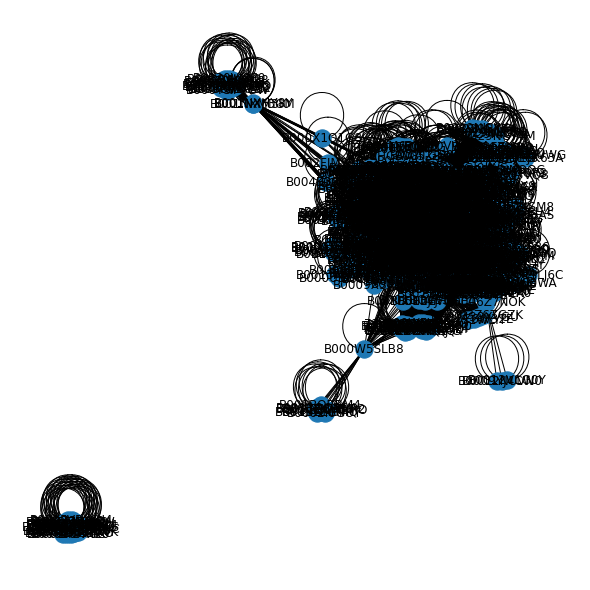

In [25]:
network_product = nx.from_pandas_adjacency(matrix1)
plt.figure(figsize=(8,8))
nx.draw_spring(network_product, with_labels=True)

Constructing and sketching a network for users. 

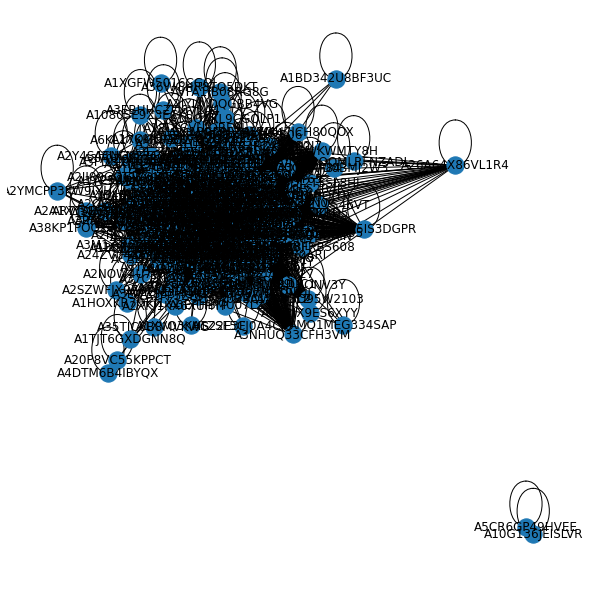

In [26]:
network_user = nx.from_pandas_adjacency(matrix2)
plt.figure(figsize=(8,8))
nx.draw_spring(network_user, with_labels=True)

The obtained networks are too complicated to understand.

### Step 10

Removing some edges by setting threshold for each graph.

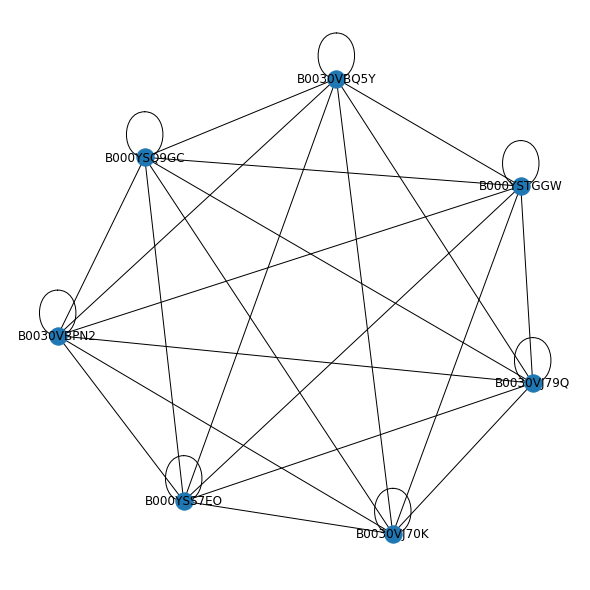

In [132]:
threshold = matrix1.sum(axis=0)>12.75
graph1 = nx.from_pandas_adjacency(matrix1.loc[threshold,threshold])
plt.figure(figsize=(8,8))
nx.draw_spring(graph1, with_labels=True)

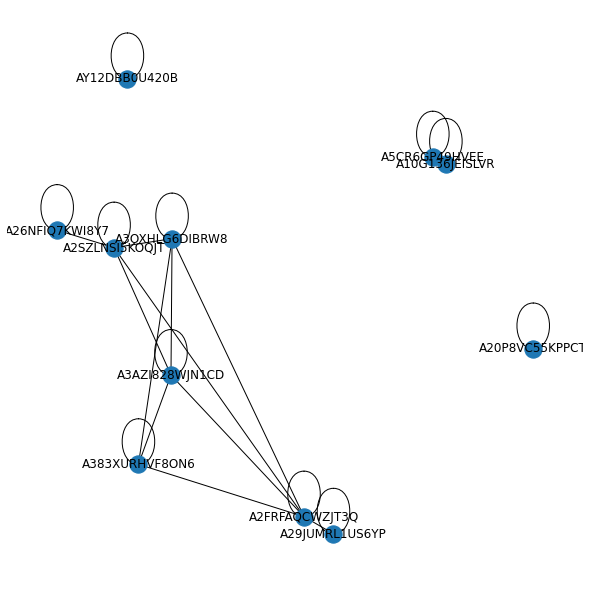

In [358]:
threshold1 = matrix2.sum(axis=0)>9.1842
graph2 = nx.from_pandas_adjacency(matrix2.loc[threshold1,threshold1])
plt.figure(figsize=(8,8))
nx.draw_spring(graph2, with_labels=True)

# Question 2

For this question we are going to use the audio track of the following [YouTube video](https://www.youtube.com/watch?v=VHoT4N43jK8&ab_channel=StromaeVEVO). I downloaded the audio track for you locally [here](https://github.com/kaygun/2022-Fall-381E/blob/90f5859d24cb1af558a795cfca797bf637bbb048/data/stromae_alors_on_danse.opus)

**Step 1:** Create a chromagram for the audio.

**Step 2:** Round the resulting matrix using np.round with rounding parameter 0.

**Step 3:** The result is a matrix of size (12,9083). The number of rows correspond to the notes in an octave: "C","C#","D","D#","E","F","F#","G","G#","A","A#","B".

**Step 4:** Count the number of each note using the result of Step 3, and sketch a histogram.

**Step 5:** What are the top 5 notes appearing in the song?

## Answers

In [27]:
raw, fs = librosa.load('data_stromae_alors_on_danse.opus', mono=True, duration=234)
song = raw[350000:5000000]

### Step 1

Creating a chromagram for the audio.

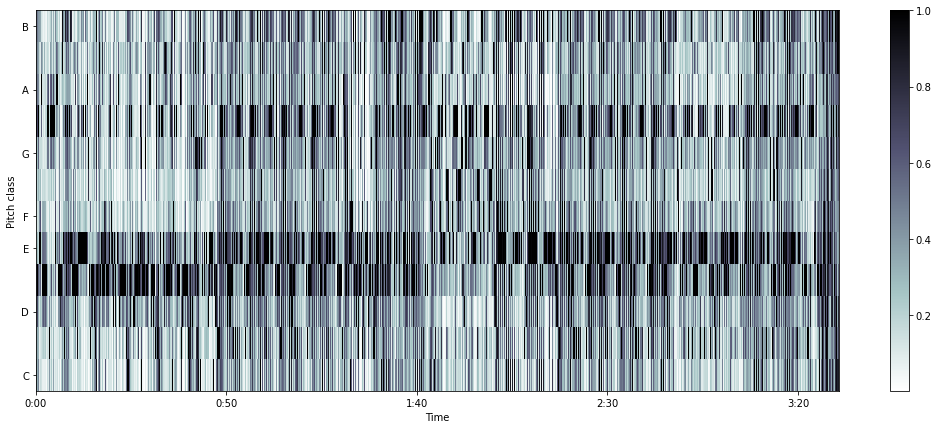

In [381]:
chromagram = librosa.feature.chroma_stft(y=song, sr=fs)
plt.figure(figsize=(18, 7))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='bone_r')
plt.colorbar()

### Step 2

Rounding the resulting matrix using np.round with rounding parameter 0.

In [30]:
rounded = np.round(chromagram,decimals=0)
rounded

array([[1., 1., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.]], dtype=float32)

### Step 3

In [31]:
np.shape(rounded)

(12, 9083)

In [33]:
notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
notes

['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

### Step 4

Counting the number of each note and sketching a histogram.

In [35]:
nf = [np.count_nonzero(i) for i in rounded]
nf

[2103, 3040, 2856, 4844, 5380, 2021, 1880, 2747, 4234, 2197, 2207, 2984]

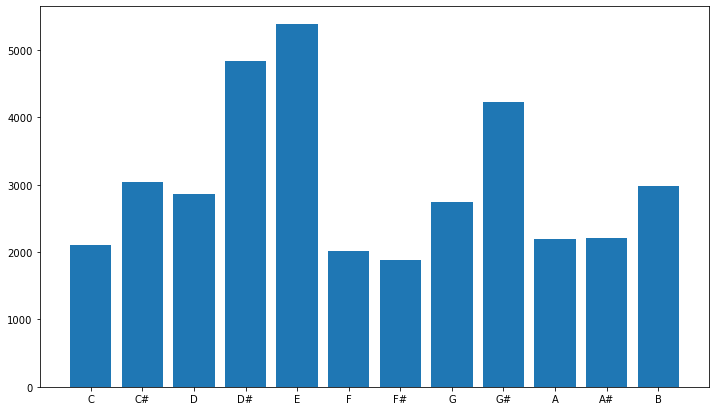

In [40]:
counts = list(zip(notes, nf))
labels, values = zip(*counts)
plt.figure(figsize=(12,7))
plt.bar(labels,values)
plt.show()

### Step 5

Finding the top 5 notes that appear in the song.

In [379]:
counts.sort(key=lambda x: x[1], reverse=True)
top_notes = counts[:5]
print("Top 5 Notes")
for i, x in top_notes:
    print(f"{i}: appears {x} times.")

Top 5 Notes
E: appears 5380 times.
D#: appears 4844 times.
G#: appears 4234 times.
C#: appears 3040 times.
B: appears 2984 times.
